In [1]:
import os
os.environ["PLAIDML_NATIVE_PATH"] = "/Users/ryosuke/anaconda3/envs/kerasenv/lib/libplaidml.dylib"
os.environ["RUNFILES_DIR"] = "/Users/ryosuke/anaconda3/envs/kerasenv/share/plaidml"
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import plaidml.keras
plaidml.keras.install_backend() #バックエンドに設定
import keras
print(keras.backend.backend()) #Kerasのバックエンドの確認
from keras import layers
from keras.utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np

plaidml


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#generatorの出力をtanhとしたので
#各ピクセルが[-1,1]の値を取るように正規化
x_train = (x_train.astype('float32')-127.5)/ 127.5
x_train = x_train.reshape(x_train.shape + (1,))
x_test = (x_test.astype('float32')-127.5)/ 127.5
x_test = x_test.reshape(x_test.shape + (1,))

print(x_train.shape)
print(y_train[0])

(60000, 28, 28, 1)
5


In [3]:
#ラベルをone-hot表現に変換
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[0])

#discriminator用のラベルデータを作成
discriminator_label = np.ones((y_train.shape[0], 28, 28, 10))
for i in range(y_train.shape[0]):
    discriminator_label[i][:][:][y_train[i]] = 0

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [4]:
latent_dim = 100

#ラベルのクラス数（0〜9までの１０種類）
class_num = 10

#重み初期化
init = keras.initializers.RandomNormal(stddev=0.02)

#Adam最適化
adam = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipvalue=1.0, decay=1e-8)

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


In [5]:
#generatorモデルを作成する関数
#100次元のノイズにラベルをconcatenateしたものを入力し、28*28*1の行列を生成
def build_generator(latent_dim):
    generator_input = keras.Input(shape=(latent_dim + class_num,))
    
    #全結合層とReshapeを用いて潜在変数を７*7*256channelに変換
    x = layers.Dense(7 * 7 * 256, kernel_initializer=init, bias_initializer='zeros')(generator_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 256))(x)
    
    #7*7*256channel→14*14*128channel
    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', kernel_initializer=init, bias_initializer='zeros')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    #14*14*128channel→28*28*64channel
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', kernel_initializer=init, bias_initializer='zeros')(x)
    x = layers.LeakyReLU(0.2)(x)
    
    #28*28*64channel→28*28*1channel
    x = layers.Conv2D(1, 5, activation='tanh', padding='same', kernel_initializer=init, bias_initializer='zeros')(x)
    generator = keras.models.Model(generator_input, x)
    return generator

In [6]:
#generatorモデルを生成し、構造を確認
build_model_generator = build_generator(latent_dim)
build_model_generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1392384   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 64)        204864    
__________

In [7]:
#discriminatorモデルを作成する関数
def build_discriminator(img_shape):
    discriminator_input = layers.Input(img_shape)
    
    #28*28*1→14*14*128に畳み込み
    x = layers.Conv2D(128, 5, strides=2,padding='same',kernel_initializer=init)(discriminator_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    #14*14*128→7*7*256に畳み込み
    x = layers.Conv2D(256, 5, strides=2,padding='same',kernel_initializer=init)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    #GrobalAveragePoolingで２５６次元に
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    discriminator = keras.models.Model(discriminator_input, x)
    discriminator_optimizer  = adam
    discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
    return discriminator

In [8]:
#discriminatorモデルを生成し、構造を確認
build_model_discriminator = build_discriminator((28,28,11))
build_model_discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 11)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       35328     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 256)         0         
__________

In [9]:
#combinedモデルを生成する関数
#discriminatorの学習を止めてgeneratorを学習させる
#ラベルを入力する
def build_combined(latent_dim, class_num, generator, discriminator):
    #識別ネットワークの学習を止める
    discriminator.trainable = False
    
    #input①100次元のノイズ+ラベルをone-hot表現で変換した10次元のベクトル
    combined_input = keras.Input(shape=((latent_dim + class_num),))
        
    #input②ラベルを28*28*10で表現したデータ
    discriminator_label = keras.Input(shape=(28,28,class_num))
    
    #画像を生成する
    generated_image = generator(combined_input)
    
    #生成画像とラベルをconcatenateする
    discriminator_input = layers.Concatenate(axis=3)([generated_image,discriminator_label])
    
    #generatorの学習
    combined_output = discriminator(discriminator_input)
    combined = keras.models.Model([combined_input, discriminator_label], combined_output)
    combined_optimizer = adam
    combined.compile(optimizer=combined_optimizer, loss='binary_crossentropy')
    return combined

In [10]:
#combinedモデルを生成し、構造を確認
build_model_combined = build_combined(latent_dim, class_num, build_model_generator, build_model_discriminator)
build_model_combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 110)          0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28, 1)    2418177     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 28, 28, 10)   0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 28, 28, 11)   0           model_1[1][0]                    
                                                                 input_4[0][0]                    
__________

In [11]:
#学習の実行
epochs = 100

batch_size = 128
half_batch_size = int(batch_size / 2)

batchSize=batch_size
batchCount = x_train.shape[0] / batchSize
print ('Epochs:', epochs)
print ('Batch size:', batchSize)
print ('Batches per epoch:', batchCount)

for epoch in range(1, epochs+1):
    
    print('-'*15, 'Epoch %d' % epoch, '-'*15)
    
    #for i in tqdm(range(int(batchCount))):
    for i in range(int(batchCount)):
        
        #ラベルとして用いるデータを決定
        batch_iterate = np.random.randint(0, x_train.shape[0], size=half_batch_size)
        
        #ランダムに潜在変数を生成
        random_latent_vectors = np.random.normal(size=(half_batch_size, latent_dim))
        
        #generatorに入力するためのデータ作成
        gen_input = np.concatenate([random_latent_vectors, y_train_categorical[batch_iterate]], axis=1)
        
        #潜在変数を元にgeneratorで画像を生成
        generated_img = build_model_generator.predict(gen_input)
        
        #discriminatorのinput用に画像とラベルを結合したものを作成
        dis_input_fake = np.concatenate([generated_img, discriminator_label[batch_iterate]], axis=3)
        
        
        #本物として用いるデータを決定
        real_iterate = np.random.randint(0, x_train.shape[0], size=half_batch_size)
        
        #本物の画像
        real_img = x_train[real_iterate]
        
        #本物の画像のラベル
        real_label = discriminator_label[real_iterate]
        
        #入力用の本物のデータ
        dis_input_real = np.concatenate([real_img, real_label], axis=3)
        
        #inputを作成
        combined_input = np.concatenate([dis_input_fake, dis_input_real])
        
        
        #生成した画像のラベルを0(偽物)、本物の画像のラベルを1として正解ラベルを作成
        labels = np.concatenate([np.zeros((half_batch_size, 1)),np.ones((half_batch_size, 1))])
        
        
        #---discriminatorの学習-----------------------------------------------------
            
        #discriminatorの学習実行
        d_loss = build_model_discriminator.train_on_batch(combined_input, labels)
        
        #---------------------------------------------------------------------------
        
        
        
        #---generatorの学習----------------------------------------------------------
        
        #ラベルとして用いるデータを決定
        gen_iterate = np.random.randint(0, x_train.shape[0], size=batch_size)
        
        #ランダムに潜在変数を生成
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        
        #input①100次元のノイズ+ラベルをone-hot表現で変換した10次元のベクトル
        input1 = np.concatenate([random_latent_vectors, y_train_categorical[gen_iterate]], axis=1)
        
        #input②ラベルを28*28*10で表現したデータ
        input2 = discriminator_label[gen_iterate]
        
        #全て本物のデータだと判断させるためラベルを1に設定
        fake_label = np.ones((batch_size, 1))
        
        #generatorの学習実行
        g_loss = build_model_combined.train_on_batch([input1, input2], fake_label)
        
        #---------------------------------------------------------------------------
        
    #1epoch終えるごとに損失を出力
    print('discriminator loss: %s' % (d_loss))
    print('generator loss  : %s' % (g_loss))

Epochs: 100
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


/Users/ryosuke/anaconda3/envs/kerasenv/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
INFO:plaidml:Analyzing Ops: 108 of 317 operations complete


discriminator loss: 0.6596464
generator loss  : 0.7646895
--------------- Epoch 2 ---------------
discriminator loss: 0.68984663
generator loss  : 0.66680324
--------------- Epoch 3 ---------------
discriminator loss: 0.6804489
generator loss  : 0.82462656
--------------- Epoch 4 ---------------
discriminator loss: 0.7410424
generator loss  : 0.61226225
--------------- Epoch 5 ---------------
discriminator loss: 0.68711275
generator loss  : 0.7890635
--------------- Epoch 6 ---------------
discriminator loss: 0.67079866
generator loss  : 0.70679057
--------------- Epoch 7 ---------------
discriminator loss: 0.6824107
generator loss  : 0.77767956
--------------- Epoch 8 ---------------
discriminator loss: 0.6725048
generator loss  : 0.77182007
--------------- Epoch 9 ---------------
discriminator loss: 0.67713964
generator loss  : 0.79199374
--------------- Epoch 10 ---------------
discriminator loss: 0.694222
generator loss  : 0.6578263
--------------- Epoch 11 ---------------
discrimi

In [34]:
#検証用のラベルを作成する
test_label = np.zeros((100, 10))
for i in range(0, 9):
    for j in range(0, 9):
        test_label[10*i+j][i] = 1

In [35]:
img = build_model_generator.predict(np.concatenate([np.random.normal(size=(100, latent_dim)), test_label], axis=1))

In [36]:
print(img.shape)

(100, 28, 28, 1)


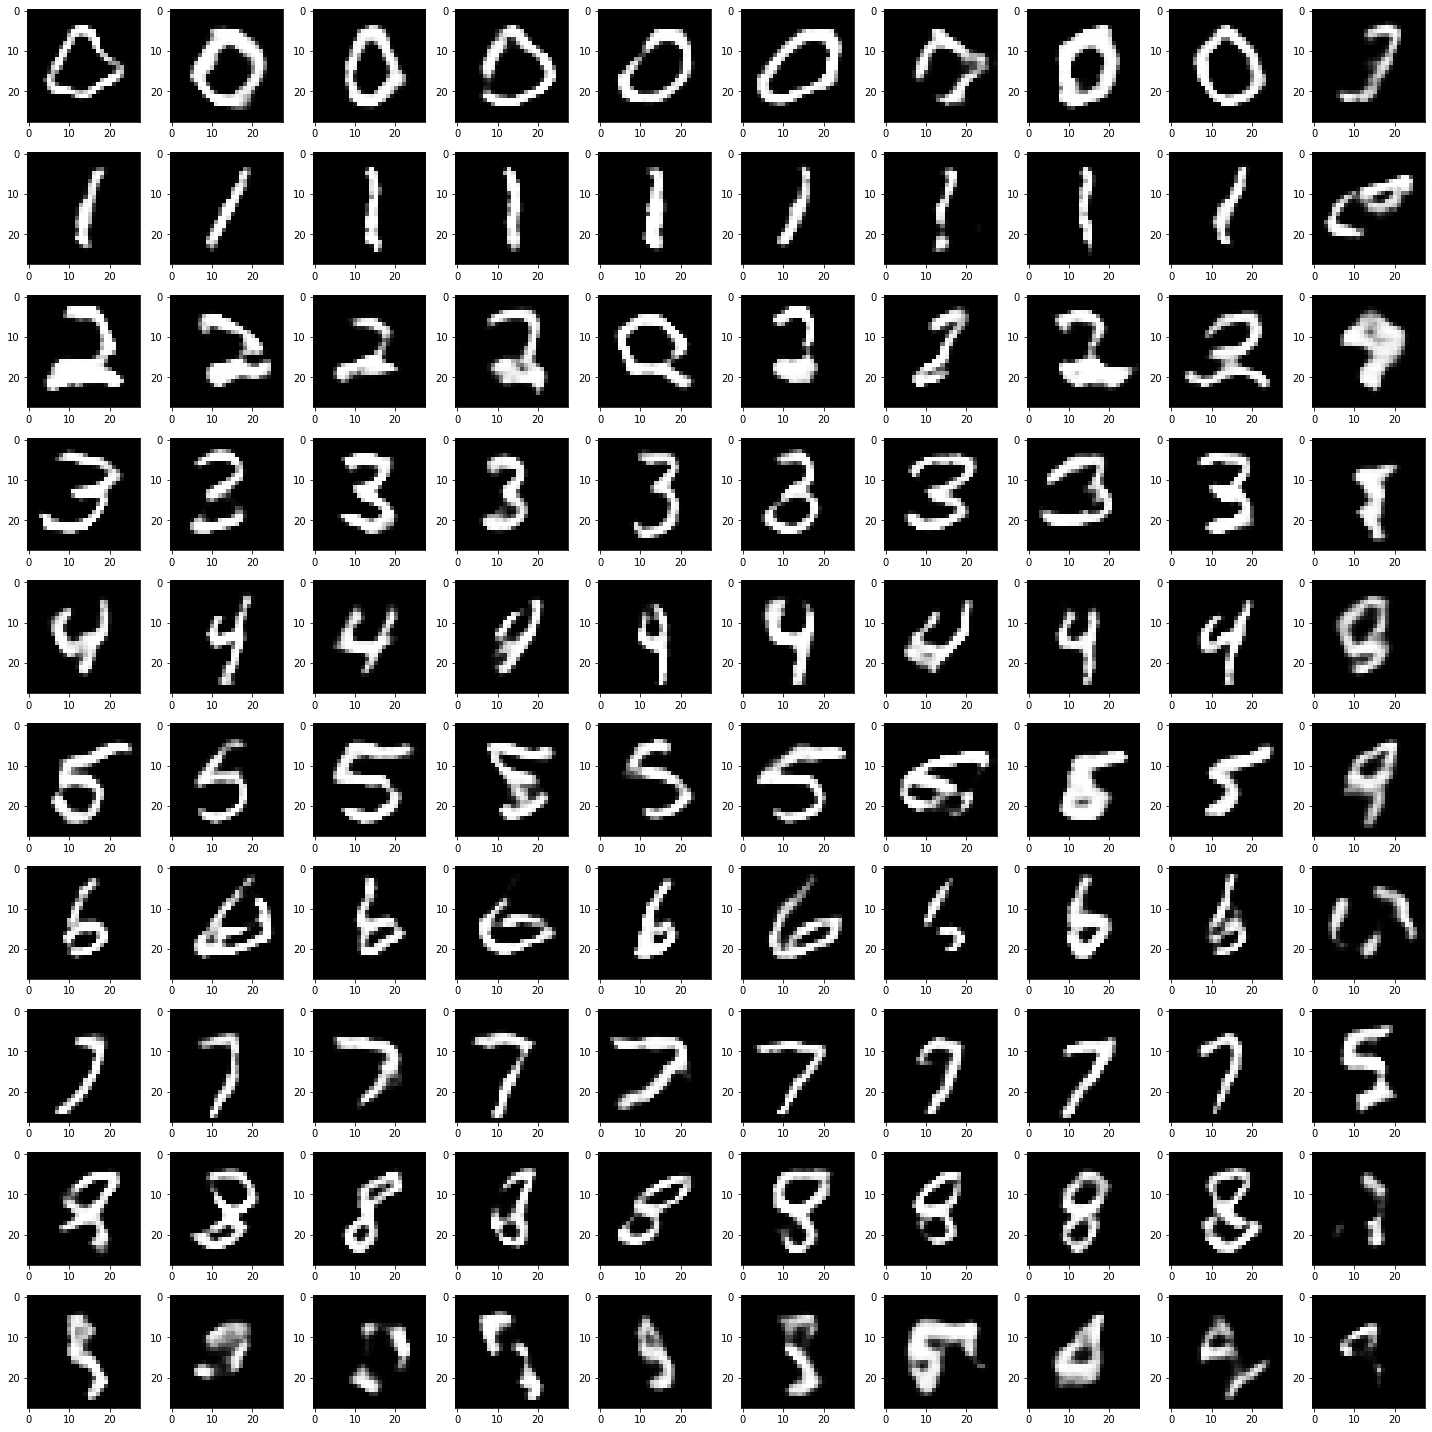

In [37]:
img = img.reshape((100,28,28))
fig = plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(img[i], cmap='gray')

plt.tight_layout()
plt.show()
